<a href="https://colab.research.google.com/github/mmagavi/FinalProject1291/blob/main/SecondModel_FinalProjectCLPS1291.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Classifying Brain Tumors With Convolutional Neural Networks and Vision Transformer**

**Model:** Vision Transformer (ViT) \
**Source:** http://pytorch.org/vision/stable/models/vision_transformer.html

## **Import Data**


Importing the data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

**cjdata.label:** 1 for meningioma, 2 for glioma, 3 for pituitary tumor

**cjdata.PID:** patient ID

**cjdata.image:** image data

**cjdata.tumorBorder:** a vector storing the coordinates of discrete points on tumor border.

		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

**cjdata.tumorMask:** a binary image with 1s indicating tumor region




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
# Importing and Downloading Images

!gdown 1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
!gdown 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
!gdown 1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
!gdown 1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
!unzip brainTumorDataPublic_22993064.zip -d tumor_data
!unzip brainTumorDataPublic_15332298.zip -d tumor_data
!unzip brainTumorDataPublic_7671532.zip -d tumor_data
!unzip brainTumorDataPublic_1766.zip -d tumor_data

Downloading...
From: https://drive.google.com/uc?id=1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
To: /content/brainTumorDataPublic_15332298.zip
100% 216M/216M [00:02<00:00, 76.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
To: /content/brainTumorDataPublic_22993064.zip
100% 232M/232M [00:02<00:00, 88.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
To: /content/brainTumorDataPublic_7671532.zip
100% 218M/218M [00:02<00:00, 99.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
To: /content/brainTumorDataPublic_1766.zip
100% 214M/214M [00:02<00:00, 79.2MB/s]
Archive:  brainTumorDataPublic_22993064.zip
  inflating: tumor_data/2299.mat     
  inflating: tumor_data/2300.mat     
  inflating: tumor_data/2301.mat     
  inflating: tumor_data/2302.mat     
  inflating: tumor_data/2303.mat     
  inflating: tumor_data/2304.mat     
  inflating: tumor_data/2305.mat     
  infla

In [3]:
#!ls tumor_data # Checking Data was loaded correctly into folder.

# **Vision Transformer (ViT) Model**
Creating, Evaluating and Training a ViT Model on our data



**Setting Up**

- Downloading packages
- Setting up environment

In [4]:
%env CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#SETUP
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchsummary import summary
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

env: CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
Running on cuda:0


**Instantiating Model**

torchvision.models.vit_b_32()

In [5]:
vit = models.vit_b_16(weights="IMAGENET1K_V1")
vit = vit.to(device)
vit.eval()
#summary(vit, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 151MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [50]:
import h5py # Import Python Library to interact with HDF5 files

image_path = "tumor_data/1571.mat" # using one image to see model works

# Open the .mat file using h5py
with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    patient_id = file['cjdata']['PID'][()][0, 0]
    image_data = file['cjdata']['image'][()]
    tumor_border = file['cjdata']['tumorBorder'][()].flatten() #make it into a 1D array of data on the border

In [51]:
# Similar code to assignment 7
# Preprocessing images

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json


def preprocess(image_data):
    data = np.repeat(image_data[..., np.newaxis], 3, -1)
    image = Image.fromarray((data * 255).astype(np.uint8))

    # Resize and normalize using PyTorch transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    normalized_image = transform(image)
    #print(normalized_image.shape)
    return normalized_image


PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)


def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')

Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 59.3MB/s]


Trying ViT before finetuning for our images

In [8]:
array = preprocess(image_data)

with torch.no_grad():
  vector = vit(array[None, :, :, :].cuda())


Class: cup, Probability: 0.21271628141403198


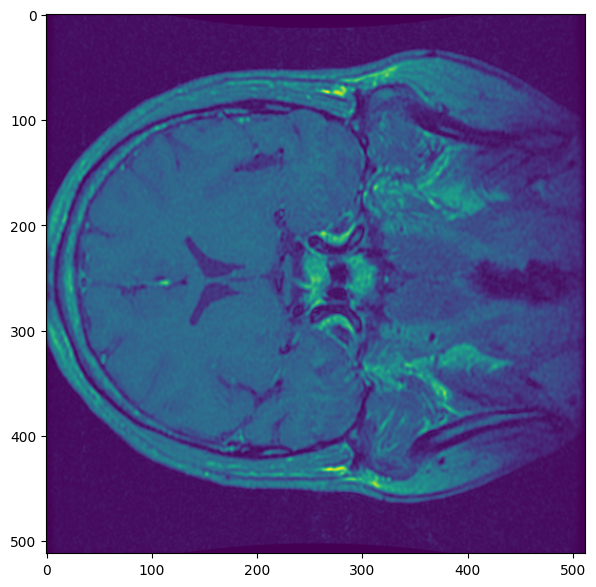

In [9]:
# Display the Image + Probability
plt.imshow(image_data)
decode_preds(vector)

**FineTuning the ViT Model**

In [10]:

from sklearn.model_selection import train_test_split
import shutil

# Create a Training, Testing, and Validation set

path = "tumor_data"
file_paths = [os.path.join(path, file) for file in os.listdir(path)]
train_files, test_val_files = train_test_split(file_paths, test_size=0.2, random_state=42)
test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

def move_files(file_list, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, destination_folder)

# Move files to their folders
move_files(train_files, "tumor_data/train")
move_files(val_files, "tumor_data/validate")
move_files(test_files, "tumor_data/test")


In [11]:
class CustomMatDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Open the .mat file using h5py
        with h5py.File(file_path, 'r') as file:
            label = file['cjdata']['label'][()][0, 0]
            label = label - 1
            # patient_id = file['cjdata']['PID'][()][0, 0]
            image_data = file['cjdata']['image'][()]
            # tumor_border = file['cjdata']['tumorBorder'][()].flatten()

        if self.transform:
            image = self.transform(image_data)

        return image, label

train_dataset = CustomMatDataset(folder_path='tumor_data/train', transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomMatDataset(folder_path='tumor_data/test', transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

validate_dataset = CustomMatDataset(folder_path='tumor_data/validate', transform=preprocess)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True)


Setting up the new labels for the new model

In [12]:
#class names
class_names = {
    0: "meningioma",
    1: "glioma",
    2: "pituitary tumor",
}

In [13]:
# Akash's code
standard_vit = models.vit_b_32(weights="IMAGENET1K_V1").to(device)

# Not! freezing the previous layers of the ViT (in order to finetune it)
for param in standard_vit.parameters():
    param.requires_grad = True

# Modify the model for 3-class classification of Brain images, Remove the fully connected layers (classifier) on top
standard_vit.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 3),  #3 classes of tumours
            nn.Softmax(dim=1) # Added
        )

# Now create a new model with the features of the standard VIT and a new classifier (fully connected layers)
class NewVIT(nn.Module):
    def __init__(self):
        super(NewVIT, self).__init__()
        self.oldvit = standard_vit

    def forward(self, x):
        x = self.oldvit(x)
        return x

new_vit = NewVIT()

#print(new_vit)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 139MB/s]


By this point we have added three layers to our vision transformer model, as well as creating a new classifier.

Now, we will train and test the updated model with our training and testing datasets that we defined above.

In [14]:
# Code adapted from: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

from tqdm import tqdm, trange
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

**Training**

In [32]:
# Define Training Function
def train(model, epochs, lr, train_loader, validate_loader):

    # Training loop
    optimizer = Adam(model.parameters(), lr=lr)
    print(model.parameters())
    criterion = CrossEntropyLoss()
    accs= []

    for epoch in trange(epochs, desc="Training"):
        train_loss = 0.0

        #for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y = y.long()  # make into int64 long
            y_hat = model(x)
            loss = criterion(y_hat, y)


            train_loss += loss.detach().cpu().item() / len(train_loader)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
          val_acc = []
          for (batch_X, batch_y) in validate_loader:
            val_outputs = model(batch_X.cuda())
            val_loss = criterion(val_outputs, batch_y.long().cuda())

            # If y_val is one-hot encoded
            _, val_preds = torch.max(val_outputs, 1)
            # _, yv = torch.max(batch_y, 1)

            val_acc.append((val_preds == batch_y.cuda()).float().mean().item())
          accs.append(np.mean(val_acc))

        print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")
        print(f"Epoch {epoch + 1}/{epochs} loss: {train_loss:.2f}")

    return accs

In [33]:
# Call Training Function
val = train(new_vit, 20, 0.001, train_loader, validate_loader)

<generator object Module.parameters at 0x7e166191af80>


Training:   5%|▌         | 1/20 [00:59<18:57, 59.84s/it]

Validation Loss: 0.4244, Validation Accuracy: 0.7633
Epoch 1/20 loss: 0.62


Training:  10%|█         | 2/20 [02:05<19:03, 63.52s/it]

Validation Loss: 0.3287, Validation Accuracy: 0.7770
Epoch 2/20 loss: 0.58


Training:  15%|█▌        | 3/20 [03:03<17:10, 60.63s/it]

Validation Loss: 0.4573, Validation Accuracy: 0.7738
Epoch 3/20 loss: 0.56


Training:  20%|██        | 4/20 [04:06<16:28, 61.80s/it]

Validation Loss: 0.6950, Validation Accuracy: 0.7559
Epoch 4/20 loss: 0.61


Training:  25%|██▌       | 5/20 [05:03<14:58, 59.88s/it]

Validation Loss: 0.3531, Validation Accuracy: 0.7520
Epoch 5/20 loss: 0.56


Training:  30%|███       | 6/20 [05:59<13:42, 58.72s/it]

Validation Loss: 0.4185, Validation Accuracy: 0.7539
Epoch 6/20 loss: 0.54


Training:  35%|███▌      | 7/20 [06:57<12:37, 58.27s/it]

Validation Loss: 0.3580, Validation Accuracy: 0.7738
Epoch 7/20 loss: 0.55


Training:  40%|████      | 8/20 [07:52<11:29, 57.44s/it]

Validation Loss: 0.3099, Validation Accuracy: 0.7238
Epoch 8/20 loss: 0.54


Training:  45%|████▌     | 9/20 [08:47<10:21, 56.53s/it]

Validation Loss: 1.0310, Validation Accuracy: 0.7298
Epoch 9/20 loss: 0.56


Training:  50%|█████     | 10/20 [09:41<09:18, 55.90s/it]

Validation Loss: 0.4794, Validation Accuracy: 0.8186
Epoch 10/20 loss: 0.52


Training:  55%|█████▌    | 11/20 [10:36<08:18, 55.42s/it]

Validation Loss: 0.4786, Validation Accuracy: 0.7936
Epoch 11/20 loss: 0.52


Training:  60%|██████    | 12/20 [11:30<07:21, 55.19s/it]

Validation Loss: 0.7624, Validation Accuracy: 0.7788
Epoch 12/20 loss: 0.52


Training:  65%|██████▌   | 13/20 [12:24<06:24, 54.90s/it]

Validation Loss: 0.7606, Validation Accuracy: 0.7674
Epoch 13/20 loss: 0.56


Training:  70%|███████   | 14/20 [13:19<05:28, 54.73s/it]

Validation Loss: 0.4418, Validation Accuracy: 0.7842
Epoch 14/20 loss: 0.52


Training:  75%|███████▌  | 15/20 [14:13<04:33, 54.65s/it]

Validation Loss: 0.7924, Validation Accuracy: 0.7715
Epoch 15/20 loss: 0.52


Training:  80%|████████  | 16/20 [15:09<03:39, 54.90s/it]

Validation Loss: 0.7722, Validation Accuracy: 0.7571
Epoch 16/20 loss: 0.51


Training:  85%|████████▌ | 17/20 [16:05<02:46, 55.43s/it]

Validation Loss: 0.5531, Validation Accuracy: 0.7028
Epoch 17/20 loss: 0.57


Training:  90%|█████████ | 18/20 [17:00<01:50, 55.30s/it]

Validation Loss: 0.2700, Validation Accuracy: 0.7645
Epoch 18/20 loss: 0.53


Training:  95%|█████████▌| 19/20 [17:55<00:55, 55.15s/it]

Validation Loss: 0.5085, Validation Accuracy: 0.7842
Epoch 19/20 loss: 0.50


Training: 100%|██████████| 20/20 [18:50<00:00, 56.51s/it]

Validation Loss: 0.5562, Validation Accuracy: 0.8092
Epoch 20/20 loss: 0.53


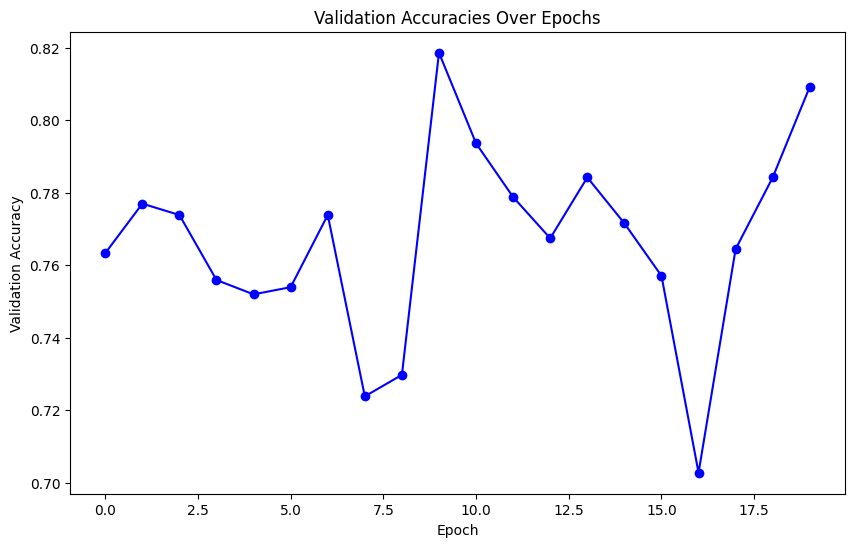

In [34]:
# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

Training:   5%|▌         | 1/20 [00:59<18:45, 59.26s/it]Validation Loss: 0.4010, Validation Accuracy: 0.8133
Epoch 1/20 loss: 0.57
Training:  10%|█         | 2/20 [01:55<17:10, 57.23s/it]Validation Loss: 0.6555, Validation Accuracy: 0.8299
Epoch 2/20 loss: 0.42
Training:  15%|█▌        | 3/20 [02:51<16:09, 57.00s/it]Validation Loss: 0.2658, Validation Accuracy: 0.8197
Epoch 3/20 loss: 0.38
Training:  20%|██        | 4/20 [03:47<15:06, 56.68s/it]Validation Loss: 0.1867, Validation Accuracy: 0.8197
Epoch 4/20 loss: 0.39
Training:  25%|██▌       | 5/20 [04:42<14:01, 56.07s/it]Validation Loss: 0.1979, Validation Accuracy: 0.8416
Epoch 5/20 loss: 0.36
Training:  30%|███       | 6/20 [05:38<13:01, 55.85s/it]Validation Loss: 0.5497, Validation Accuracy: 0.8498
Epoch 6/20 loss: 0.37
Training:  35%|███▌      | 7/20 [06:34<12:06, 55.89s/it]Validation Loss: 0.7288, Validation Accuracy: 0.8518
Epoch 7/20 loss: 0.33
Training:  40%|████      | 8/20 [07:29<11:06, 55.53s/it]Validation Loss: 0.6587, Validation Accuracy: 0.8571
Epoch 8/20 loss: 0.31
Training:  45%|████▌     | 9/20 [08:24<10:09, 55.37s/it]Validation Loss: 0.1616, Validation Accuracy: 0.8469
Epoch 9/20 loss: 0.28
Training:  50%|█████     | 10/20 [09:18<09:11, 55.13s/it]Validation Loss: 0.6229, Validation Accuracy: 0.8206
Epoch 10/20 loss: 0.31
Training:  55%|█████▌    | 11/20 [10:13<08:14, 55.00s/it]Validation Loss: 0.1842, Validation Accuracy: 0.8541
Epoch 11/20 loss: 0.29
Training:  60%|██████    | 12/20 [11:08<07:19, 54.93s/it]Validation Loss: 0.8021, Validation Accuracy: 0.8383
Epoch 12/20 loss: 0.25
Training:  65%|██████▌   | 13/20 [12:03<06:24, 54.92s/it]Validation Loss: 1.2223, Validation Accuracy: 0.7725
Epoch 13/20 loss: 0.23
Training:  70%|███████   | 14/20 [12:57<05:29, 54.90s/it]Validation Loss: 0.5148, Validation Accuracy: 0.8280
Epoch 14/20 loss: 0.22
Training:  75%|███████▌  | 15/20 [13:54<04:37, 55.44s/it]Validation Loss: 0.1799, Validation Accuracy: 0.8479
Epoch 15/20 loss: 0.24
Training:  80%|████████  | 16/20 [14:49<03:41, 55.40s/it]Validation Loss: 0.6999, Validation Accuracy: 0.8561
Epoch 16/20 loss: 0.23
Training:  85%|████████▌ | 17/20 [15:45<02:46, 55.39s/it]Validation Loss: 0.2676, Validation Accuracy: 0.8477
Epoch 17/20 loss: 0.20
Training:  90%|█████████ | 18/20 [16:40<01:50, 55.38s/it]Validation Loss: 0.4631, Validation Accuracy: 0.8258
Epoch 18/20 loss: 0.20
Training:  95%|█████████▌| 19/20 [17:35<00:55, 55.35s/it]Validation Loss: 0.5594, Validation Accuracy: 0.8393
Epoch 19/20 loss: 0.19
Training: 100%|██████████| 20/20 [18:30<00:00, 55.55s/it]Validation Loss: 0.8303, Validation Accuracy: 0.8539
Epoch 20/20 loss: 0.19


<generator object Module.parameters at 0x7e166191aab0>


Training:  10%|█         | 1/10 [01:03<09:27, 63.02s/it]

Validation Loss: 1.0321, Validation Accuracy: 0.5632
Epoch 1/10 loss: 1.26


Training:  20%|██        | 2/10 [02:01<08:03, 60.47s/it]

Validation Loss: 0.8889, Validation Accuracy: 0.5882
Epoch 2/10 loss: 0.98


Training:  30%|███       | 3/10 [03:00<06:57, 59.66s/it]

Validation Loss: 0.9862, Validation Accuracy: 0.4650
Epoch 3/10 loss: 0.91


Training:  40%|████      | 4/10 [03:56<05:50, 58.35s/it]

Validation Loss: 1.0666, Validation Accuracy: 0.5025
Epoch 4/10 loss: 1.09


Training:  50%|█████     | 5/10 [04:52<04:47, 57.54s/it]

Validation Loss: 0.5079, Validation Accuracy: 0.7155
Epoch 5/10 loss: 0.88


Training:  60%|██████    | 6/10 [05:49<03:48, 57.10s/it]

Validation Loss: 1.1117, Validation Accuracy: 0.4617
Epoch 6/10 loss: 0.93


Training:  70%|███████   | 7/10 [06:45<02:50, 56.90s/it]

Validation Loss: 1.2362, Validation Accuracy: 0.5337
Epoch 7/10 loss: 0.97


Training:  80%|████████  | 8/10 [07:41<01:53, 56.63s/it]

Validation Loss: 1.0838, Validation Accuracy: 0.6329
Epoch 8/10 loss: 0.92


Training:  90%|█████████ | 9/10 [08:40<00:57, 57.17s/it]

Validation Loss: 0.7540, Validation Accuracy: 0.6882
Epoch 9/10 loss: 0.86


Training: 100%|██████████| 10/10 [09:35<00:00, 57.52s/it]

Validation Loss: 1.1054, Validation Accuracy: 0.4607
Epoch 10/10 loss: 1.04


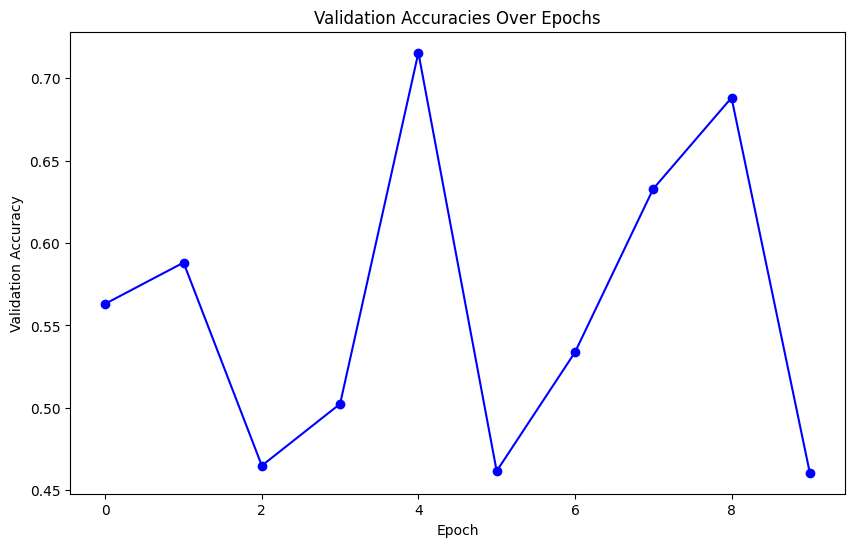

In [23]:
# 10 epochs, 0.01
val2 = train(new_vit, 10, 0.01, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val2, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

<generator object Module.parameters at 0x7e166191b300>


Training:  10%|█         | 1/10 [01:03<09:27, 63.09s/it]

Validation Loss: 0.8619, Validation Accuracy: 0.5393
Epoch 1/10 loss: 0.99


Training:  20%|██        | 2/10 [02:00<07:59, 59.90s/it]

Validation Loss: 0.7093, Validation Accuracy: 0.6059
Epoch 2/10 loss: 0.84


Training:  30%|███       | 3/10 [02:57<06:48, 58.40s/it]

Validation Loss: 0.6037, Validation Accuracy: 0.6403
Epoch 3/10 loss: 0.77


Training:  40%|████      | 4/10 [03:53<05:44, 57.49s/it]

Validation Loss: 1.2309, Validation Accuracy: 0.6495
Epoch 4/10 loss: 0.72


Training:  50%|█████     | 5/10 [04:49<04:44, 56.92s/it]

Validation Loss: 0.7326, Validation Accuracy: 0.7049
Epoch 5/10 loss: 0.70


Training:  60%|██████    | 6/10 [05:47<03:49, 57.31s/it]

Validation Loss: 0.7531, Validation Accuracy: 0.7237
Epoch 6/10 loss: 0.67


Training:  70%|███████   | 7/10 [06:43<02:51, 57.00s/it]

Validation Loss: 0.7149, Validation Accuracy: 0.7289
Epoch 7/10 loss: 0.68


Training:  80%|████████  | 8/10 [07:40<01:53, 56.90s/it]

Validation Loss: 0.3490, Validation Accuracy: 0.7582
Epoch 8/10 loss: 0.65


Training:  90%|█████████ | 9/10 [08:37<00:56, 56.83s/it]

Validation Loss: 0.8253, Validation Accuracy: 0.7132
Epoch 9/10 loss: 0.62


Training: 100%|██████████| 10/10 [09:32<00:00, 57.24s/it]

Validation Loss: 0.9863, Validation Accuracy: 0.7444
Epoch 10/10 loss: 0.62


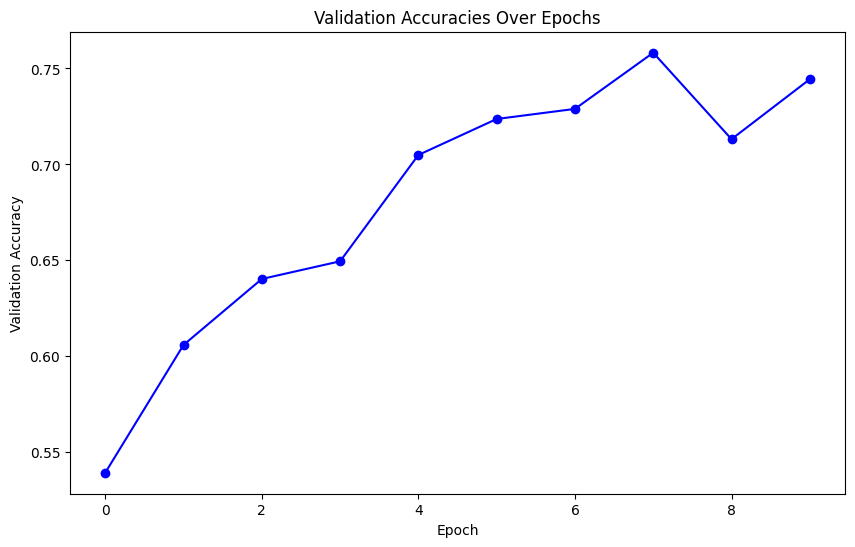

In [24]:
# 10 epochs, 0.001
val3 = train(new_vit, 10, 0.001, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val3, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

<generator object Module.parameters at 0x7e166191af80>


Training:  10%|█         | 1/10 [00:56<08:24, 56.08s/it]

Validation Loss: 0.3001, Validation Accuracy: 0.7854
Epoch 1/10 loss: 0.60


Training:  20%|██        | 2/10 [01:52<07:30, 56.33s/it]

Validation Loss: 0.7231, Validation Accuracy: 0.7821
Epoch 2/10 loss: 0.58


Training:  30%|███       | 3/10 [02:50<06:39, 57.03s/it]

Validation Loss: 0.7291, Validation Accuracy: 0.7747
Epoch 3/10 loss: 0.58


Training:  40%|████      | 4/10 [03:46<05:40, 56.79s/it]

Validation Loss: 0.7527, Validation Accuracy: 0.7747
Epoch 4/10 loss: 0.57


Training:  50%|█████     | 5/10 [04:43<04:42, 56.58s/it]

Validation Loss: 0.9648, Validation Accuracy: 0.7610
Epoch 5/10 loss: 0.57


Training:  60%|██████    | 6/10 [05:39<03:45, 56.37s/it]

Validation Loss: 0.6776, Validation Accuracy: 0.7780
Epoch 6/10 loss: 0.56


Training:  70%|███████   | 7/10 [06:35<02:49, 56.34s/it]

Validation Loss: 0.3920, Validation Accuracy: 0.7801
Epoch 7/10 loss: 0.56


Training:  80%|████████  | 8/10 [07:31<01:52, 56.15s/it]

Validation Loss: 0.2981, Validation Accuracy: 0.7801
Epoch 8/10 loss: 0.56


Training:  90%|█████████ | 9/10 [08:25<00:55, 55.71s/it]

Validation Loss: 0.5338, Validation Accuracy: 0.7696
Epoch 9/10 loss: 0.56


Training: 100%|██████████| 10/10 [09:21<00:00, 56.18s/it]

Validation Loss: 0.5781, Validation Accuracy: 0.7590
Epoch 10/10 loss: 0.55


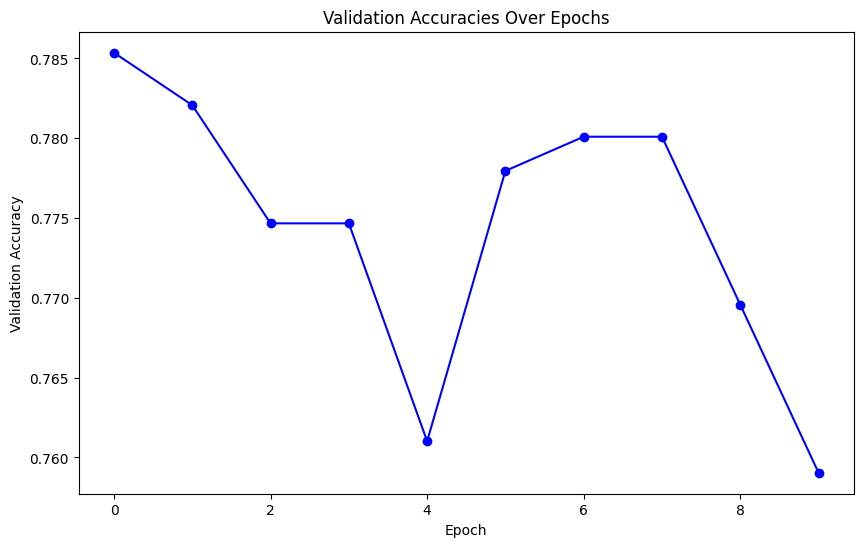

In [25]:
# 10 epochs, 0.0001
val4 = train(new_vit, 10, 0.0001, train_loader, validate_loader)

# Plot the validation accuracy over time
plt.figure(figsize=(10,6))
plt.plot(val4, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies Over Epochs')
plt.show()

**Testing** (for 20 epochs and 0.001)

In [38]:
# Define Test function
def test(model, test_loader):

    criterion = CrossEntropyLoss()

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y = y.long()  # make into int64 long
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")


In [39]:
# Call Testing Function
test(new_vit, test_loader)

Testing: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

Test loss: 0.51
Test accuracy: 79.08%


In [40]:
# New decode preds for brain data

def decode_brain_preds(outputs, class_names=class_names):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')
  return predicted_class.item()



Class: pituitary tumor, Probability: 0.8360628485679626
3.0


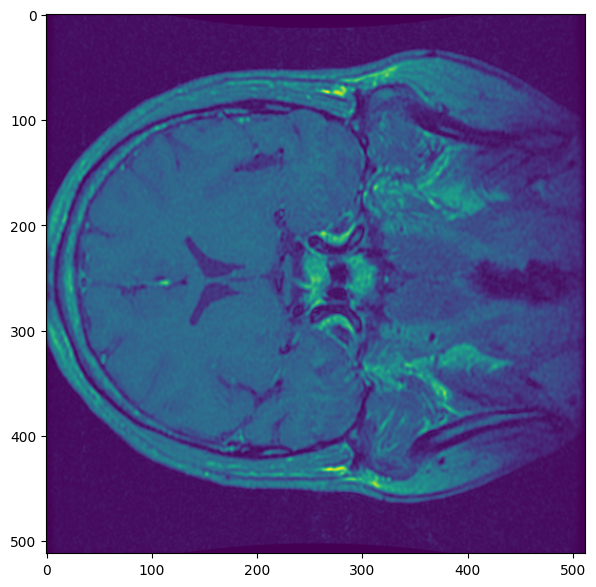

In [41]:
# Checking classification
array = preprocess(image_data)

with torch.no_grad():
  vector = new_vit(array[None, :, :, :].cuda())

# Display the image

plt.imshow(image_data) #coloured by plt.imshow()
decode_brain_preds(vector)
print(label) #to check the correct version

# **Interpretability**

In [42]:
!pip install torchvision==0.13.0
!pip install git+https://github.com/pytorch/captum.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu118
    Uninstalling torchvision-0.16.0+cu118:
      Successfully uninstalled torchvision-0.16.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.


  Cloning https://github.com/pytorch/captum.git to /tmp/pip-req-build-985e4a3e
  Running command git clone --filter=blob:none --quiet https://github.com/pytorch/captum.git /tmp/pip-req-build-985e4a3e
  Resolved https://github.com/pytorch/captum.git to commit 68d88cf6bec6a0bf73575d2d7be1b2506fdce61c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.7.0-py3-none-any.whl size=637238 sha256=5f9848a2060678addf0de0f44d2de3c5d2dd8a6155d0e9214b6022f02cea60d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxdqtqe6/wheels/8e/b7/c3/e17a61e561b99ab720ae04e56543dcd69884dee09a09bf5ae4
Successfully built captum


In [43]:
# Import captum
import numpy as np
import json
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.models as models
import captum
from captum.attr import visualization as viz
from torchvision import transforms

In [52]:
image = preprocess(image_data).to(device)
image - image.unsqueeze_(0) #preprocessed image
saliency = captum.attr.Saliency(new_vit)
attributions = saliency.attribute(image, target=0) #the attributions obtained from captum

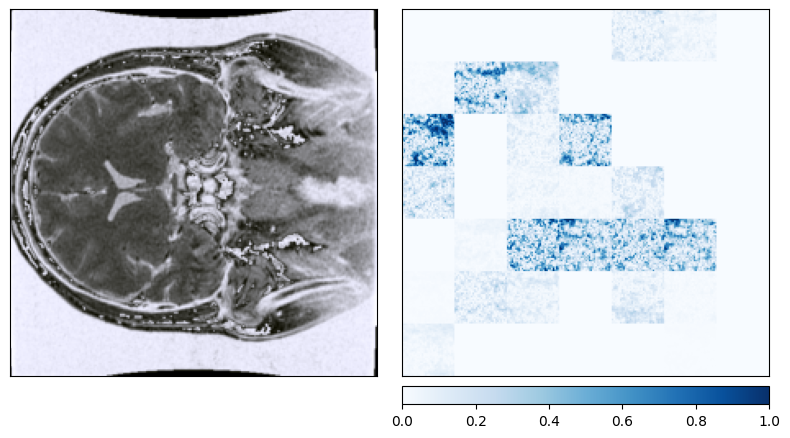

In [53]:
# The preprocessing included normalizing the image which we need invert here
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Your input image to the model.
unnorm_image = inv_normalize(image)

# Display the image and the attribution
_ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)

In [69]:
ls tumor_data/validate

1000.mat  1284.mat  1567.mat  1784.mat  200.mat   2310.mat  2572.mat  2893.mat  498.mat  730.mat
1029.mat  1306.mat  1572.mat  1794.mat  2019.mat  2337.mat  2574.mat  2894.mat  500.mat  735.mat
1040.mat  1307.mat  1576.mat  1795.mat  2021.mat  2344.mat  2578.mat  2899.mat  504.mat  742.mat
1047.mat  1310.mat  1586.mat  1797.mat  2039.mat  2348.mat  2588.mat  2903.mat  516.mat  747.mat
1076.mat  1313.mat  158.mat   1800.mat  2044.mat  2376.mat  2590.mat  2959.mat  538.mat  762.mat
1099.mat  1324.mat  1590.mat  1803.mat  2049.mat  238.mat   2594.mat  2967.mat  542.mat  782.mat
1103.mat  1326.mat  1593.mat  1804.mat  2055.mat  2390.mat  2601.mat  2983.mat  54.mat   790.mat
1132.mat  1358.mat  1597.mat  1809.mat  2069.mat  2391.mat  2603.mat  3003.mat  553.mat  797.mat
1140.mat  1378.mat  1613.mat  1824.mat  2089.mat  2392.mat  2609.mat  3019.mat  578.mat  800.mat
1141.mat  1382.mat  1616.mat  1826.mat  2095.mat  2401.mat  2628.mat  3025.mat  607.mat  801.mat
1142.mat  1395.mat  161.mat   

Testing it out with 10 different images:

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(



Class: pituitary tumor, Probability: 0.7951818108558655


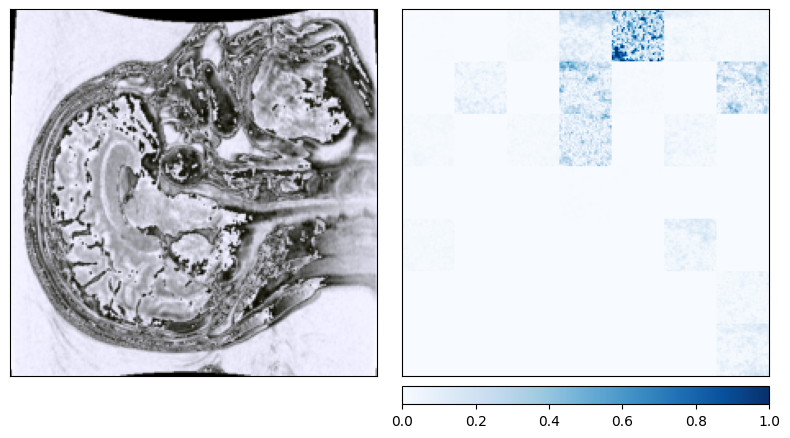


Class: meningioma, Probability: 0.6226163506507874


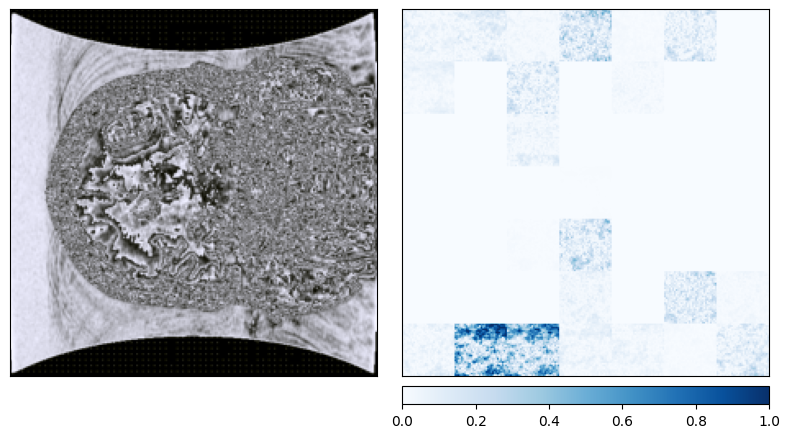


Class: pituitary tumor, Probability: 0.5238531827926636


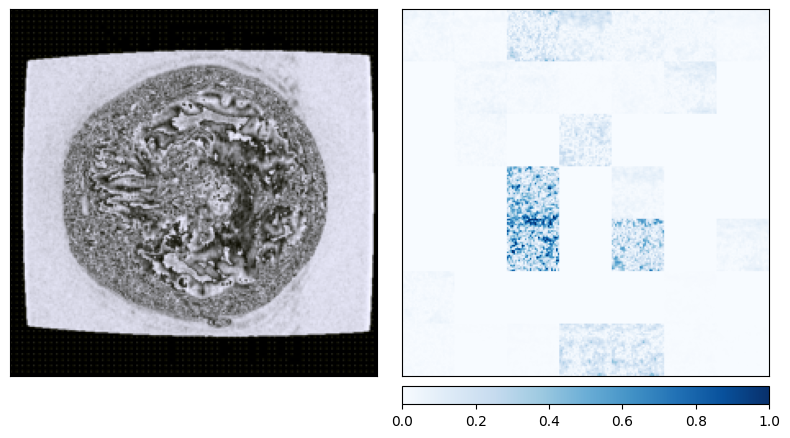


Class: meningioma, Probability: 0.7501749396324158


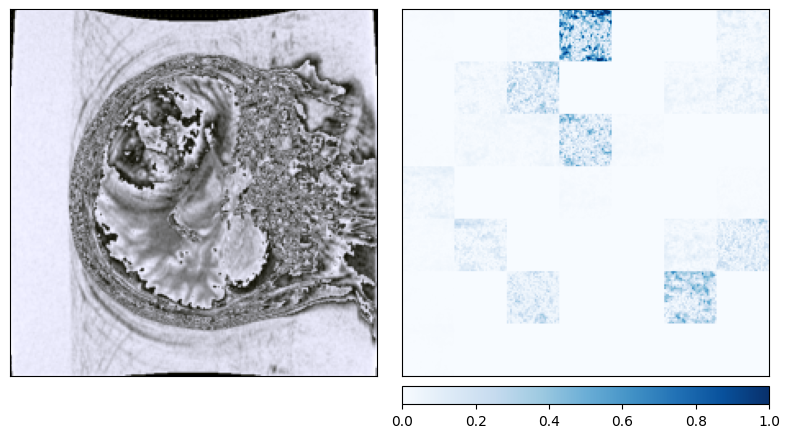


Class: meningioma, Probability: 0.7687246799468994


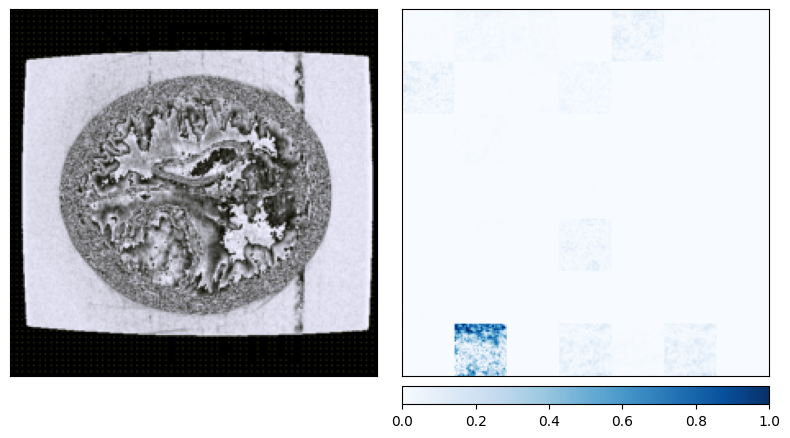


Class: glioma, Probability: 0.9983078241348267


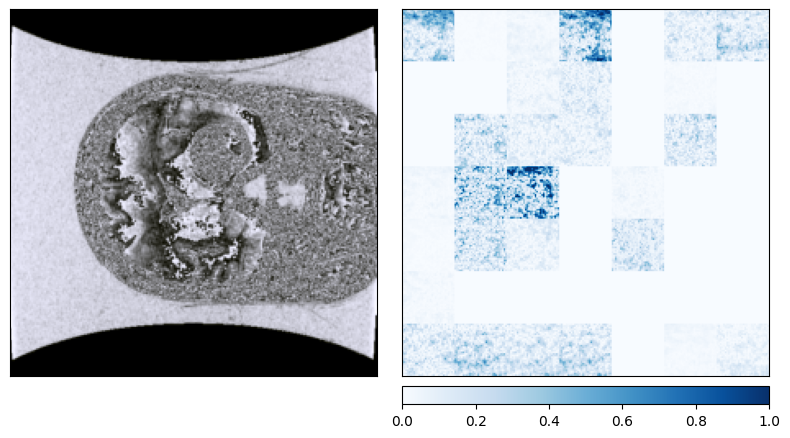


Class: glioma, Probability: 0.46369755268096924


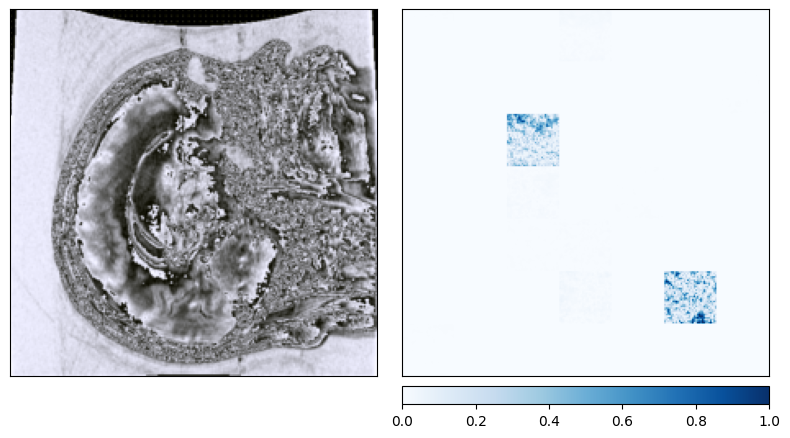


Class: pituitary tumor, Probability: 0.9648755788803101


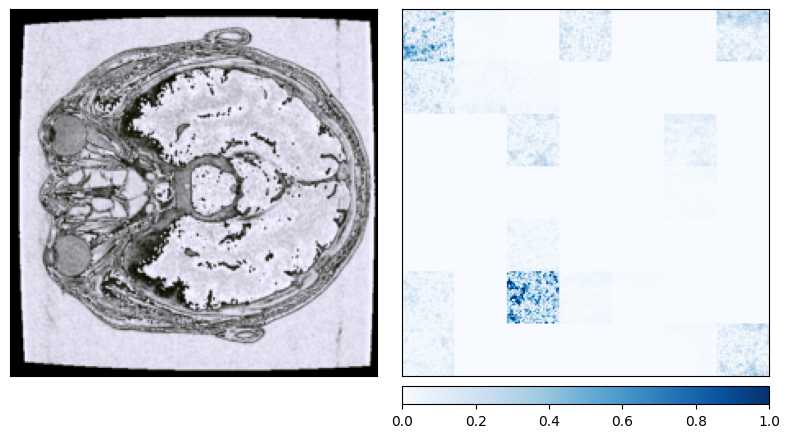


Class: pituitary tumor, Probability: 0.9432120323181152


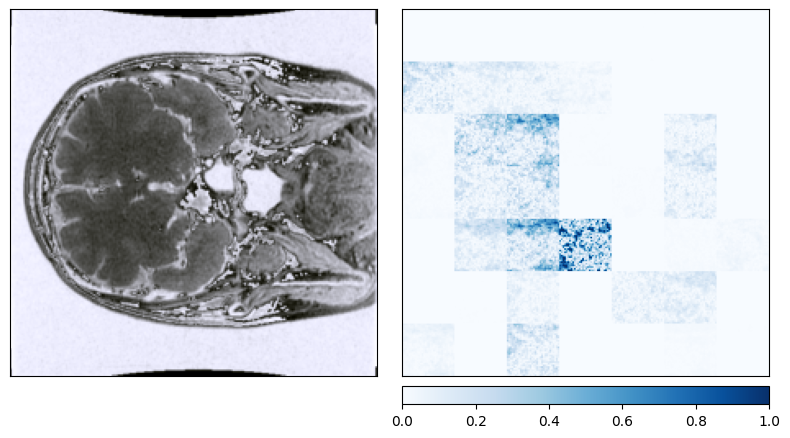


Class: meningioma, Probability: 0.5508444905281067


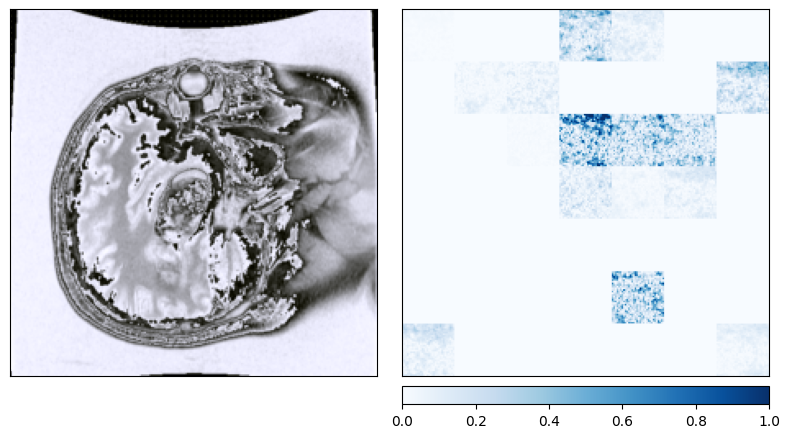


Class: glioma, Probability: 0.9973438382148743


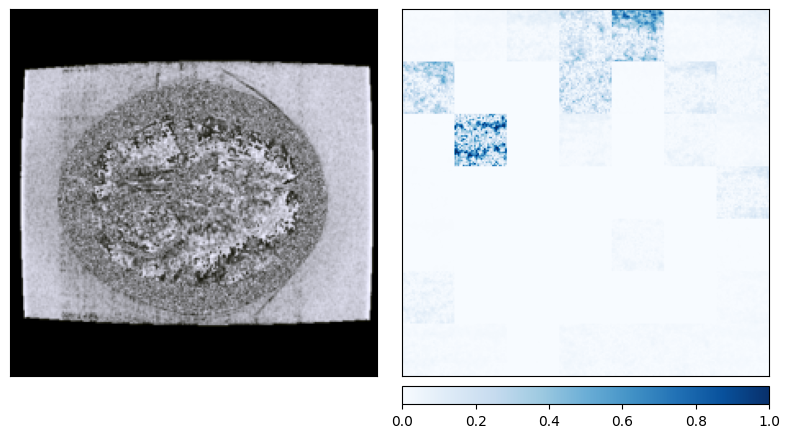


Class: meningioma, Probability: 0.46674877405166626


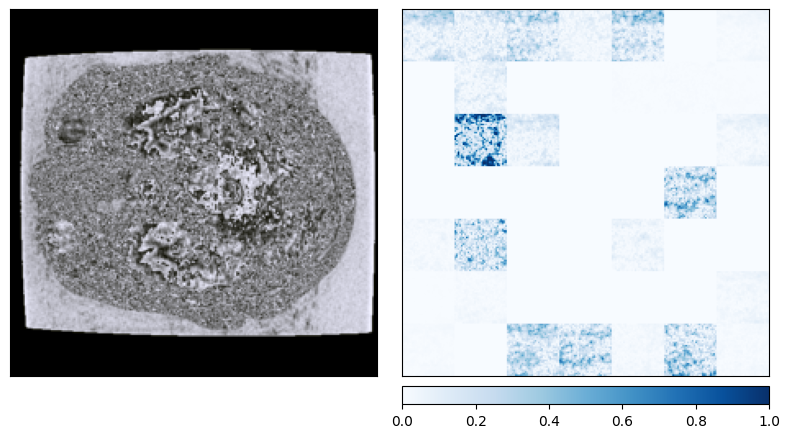

In [70]:
#10 random images
images = ['tumor_data/train/1247.mat', 'tumor_data/train/274.mat','tumor_data/train/725.mat', 'tumor_data/train/910.mat', 'tumor_data/train/171.mat',
          'tumor_data/train/2312.mat', 'tumor_data/train/864.mat', 'tumor_data/train/1416.mat',
          'tumor_data/train/1553.mat', 'tumor_data/validate/915.mat', 'tumor_data/validate/2000.mat', 'tumor_data/validate/1310.mat']

# Open the .mat file using h5py
for i, image_path in enumerate(images):

  with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    image_data = file['cjdata']['image'][()]

  array = preprocess(image_data).to(device)

  with torch.no_grad():
    vector = new_vit(array[None, :, :, :].cuda())
  index = decode_brain_preds(vector)

  saliency = captum.attr.Saliency(new_vit)
  image = array.unsqueeze_(0)
  attributions = saliency.attribute(image, target=index)

  # Your input image to the model.
  unnorm_image = inv_normalize(image)

  # Display the image and the attribution
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)